# Demo: analysing soil moisture data from the Climate Data Store in xcube

First, we import some necessary libraries and configure some matplotlib display preferences.

In [1]:
# Imports
from xcube.core.store import new_data_store
import shapely.geometry
import IPython.display
import matplotlib.pyplot as plt

# Plot settings
%matplotlib inline
plt.rcParams["figure.figsize"] = 16, 12

Create a CDS data store object. The optional `normalize_names` parameter specifies that variable names in returned data cubes will be converted to legal Python identifiers, if required.

In [2]:
cds_store = new_data_store("cds", normalize_names=True)

From the data store we request monthly averages of global volumetric soil moisture data from January 2015 to January 2016.

In [3]:
generated_cube = cds_store.open_data(
    "satellite-soil-moisture:volumetric:monthly",
    variable_names=["volumetric_surface_soil_moisture"],
    time_range=["2015-01-01", "2016-01-31"],
)
cube = generated_cube

xcube-cds version 0.9.2
2024-09-03 14:30:45,736 INFO [2023-09-10T00:00:00] An issue was reported in version v201912 of this dataset. Please consult the "Known issues" under the Documentation tab.
2024-09-03 14:30:45,736 INFO Request ID is ce0394d3-ebcb-49c3-95e2-d81f245eb2eb
2024-09-03 14:30:45,798 INFO status has been updated to accepted
2024-09-03 14:30:47,377 INFO status has been updated to running
2024-09-03 14:31:05,973 INFO Creating download object as tgz with files:
['C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-20150101000000-TCDR-v202012.0.0.nc', 'C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-20150201000000-TCDR-v202012.0.0.nc', 'C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-20150301000000-TCDR-v202012.0.0.nc', 'C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-20150401000000-TCDR-v202012.0.0.nc', 'C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-20150501000000-TCDR-v202012.0.0.nc', 'C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-20150601000000-TCDR-v202012.0.0.nc', 'C3S-SOILMOISTURE-L3S-SSMV-COMBINED

10acbc650ff9d517f5119c3acc7fd50.gz:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

Plot the bounding box on a map to check that the cube covers the expected area.

In [4]:
bbox = [min(cube.lon), min(cube.lat), max(cube.lon), max(cube.lat)]
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

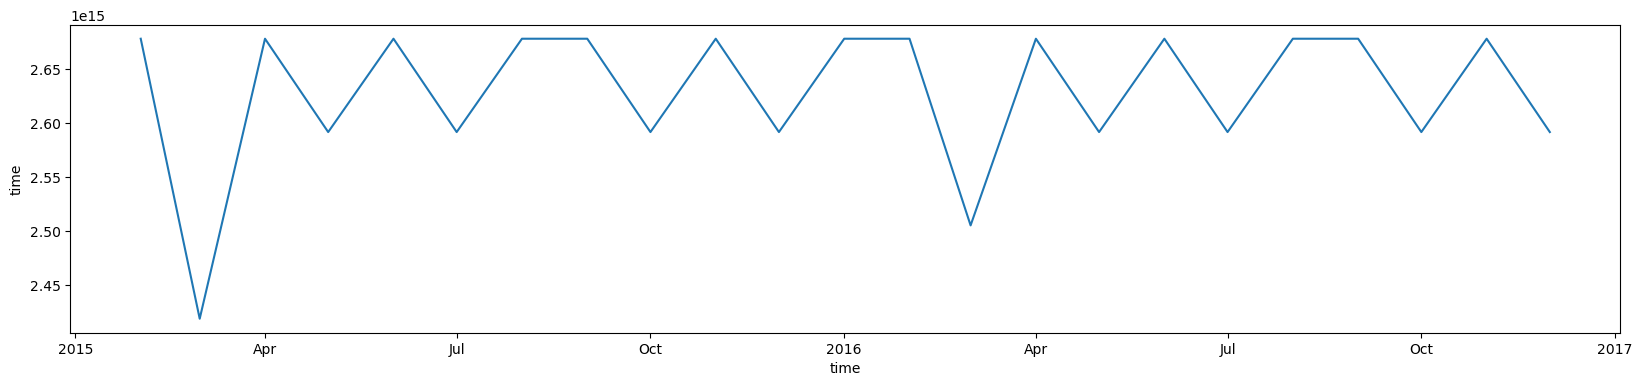

In [5]:
cube.time.diff(dim="time").plot.line(figsize=(20, 4))

As a quick initial test, we plot a simple plate carrée projection (with longitude and latitude mapped directly to the x and y co-ordinates respectively) for the first time-point available.

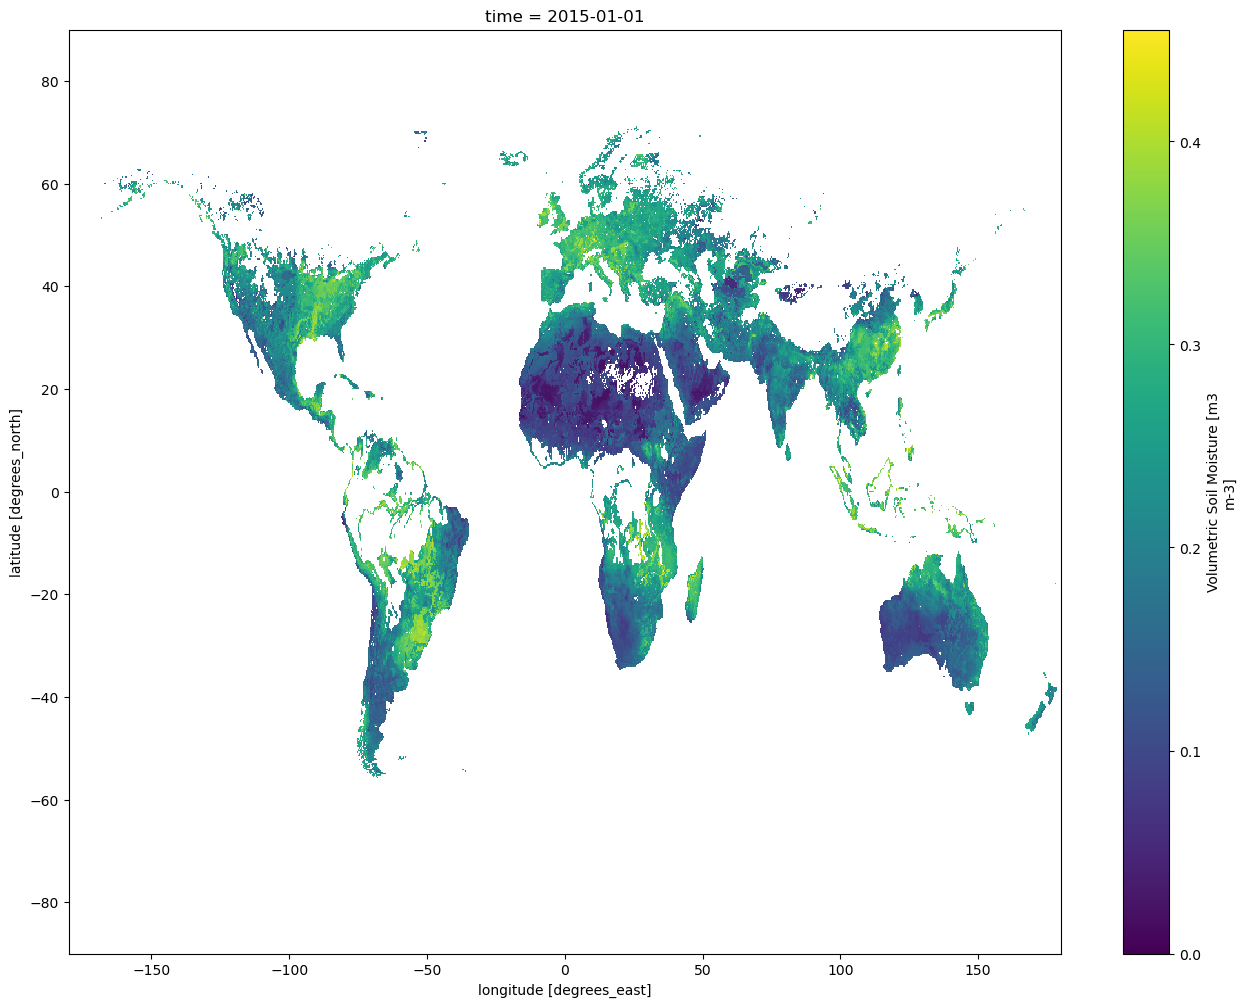

In [6]:
sm_2015_jan = cube.sm.sel(time="2015-01-01 00:00:00", method="nearest")
sm_2015_jan.plot.imshow()

Now we define a plotting function which restricts the plotted area to Europe.

In [7]:
def plot_map(data_array, colour_scale=(None, None), cmap=None):
    data_array[100:220, 670:800].plot.imshow(
        vmin=colour_scale[0], vmax=colour_scale[1], figsize=(14, 12), cmap=cmap
    )


common_scale = (260, 300)

First we plot the soil moisture for January 2015. We use an inverted version of the matplotlib ‘viridis’ colour map ranging from yellow (least moisture) to dark blue (most moisture). 

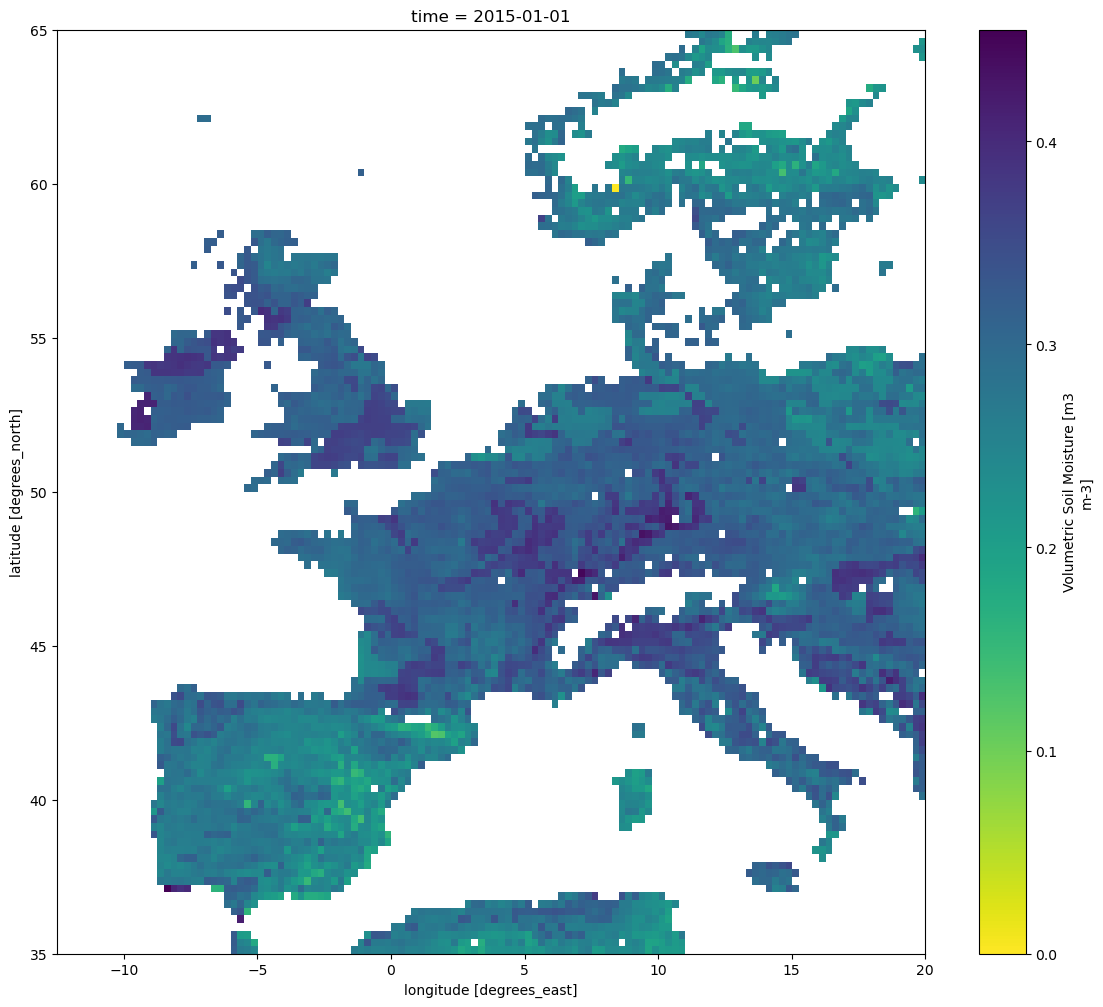

In [8]:
plot_map(sm_2015_jan, cmap="viridis_r")

For comparison, we plot the data for July 2015. Note the overall lower moisture levels (particularly in southern regions) and the improved coverage at higher altitudes and latitudes (probably due to less snow and ice cover).

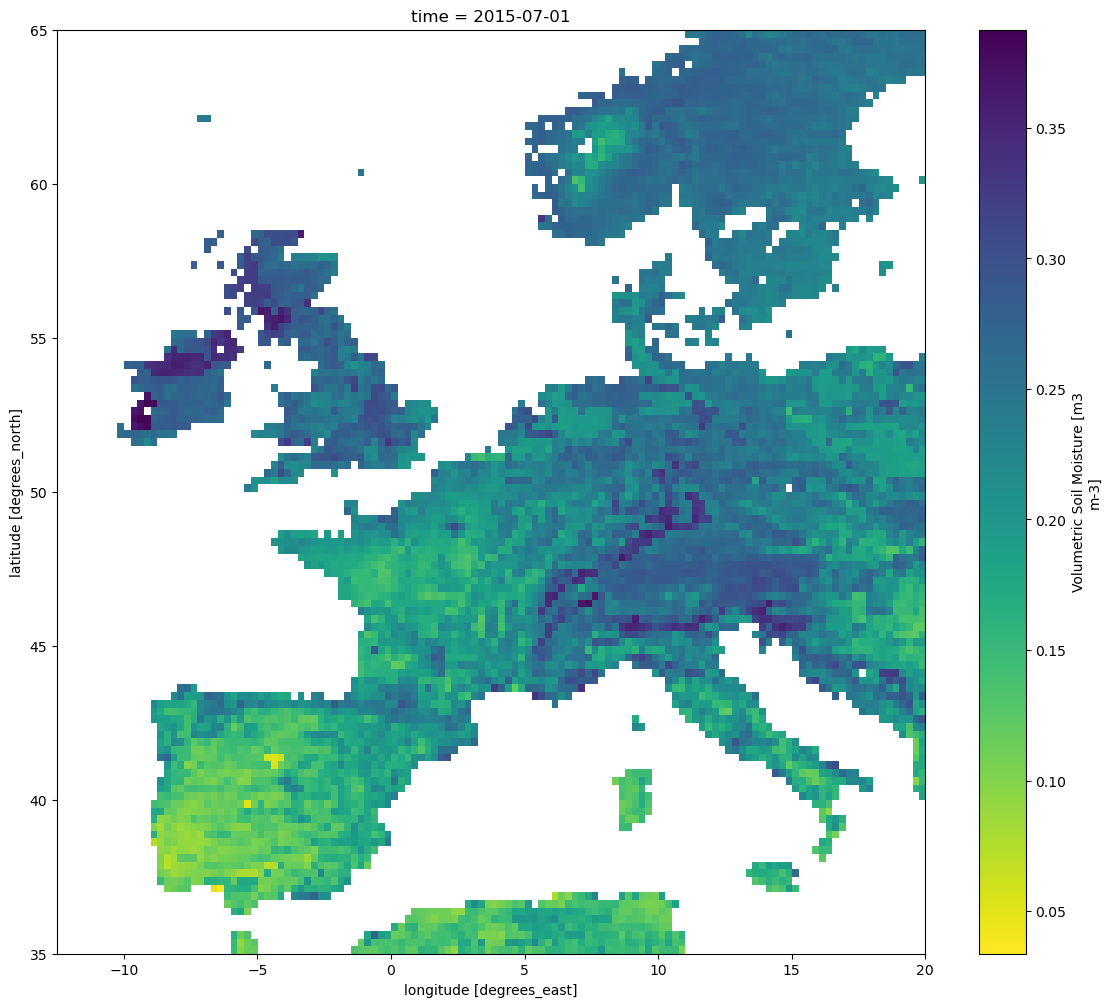

In [9]:
sm_2015_jul = cube.sm.sel(time="2015-07-01 00:00:00", method="nearest")
plot_map(sm_2015_jul, cmap="viridis_r")

By subtracting the January data from the July data, we can see more clearly where the soil moisture decreases the most in the summer.

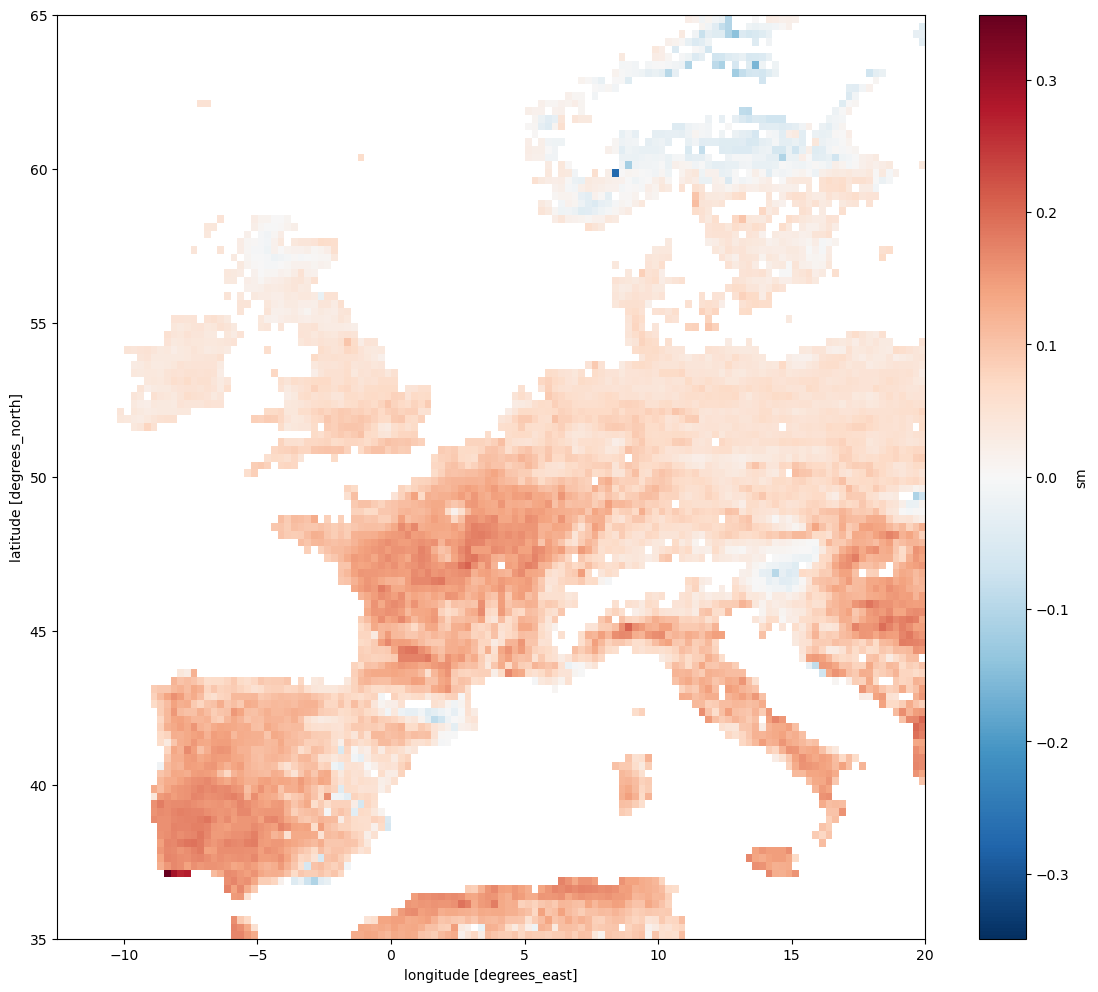

In [10]:
plot_map(sm_2015_jan - sm_2015_jul)